# AtomSCF 教程总览

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bud-primordium/AtomSCF/blob/main/docs/source/tutorials/00-overview.ipynb)

## 快速开始

本教程自动检测运行环境并安装依赖。执行下方第一个代码单元格即可开始！

## 学习目标

理解原子自洽场计算的完整逻辑链条：从 3D 原子问题到 1D 径向方程的求解。

## 完整计算流程

### 1. 物理模型简化

**3D → 1D 约化**：球对称势假设下，薛定谔方程分离变量，径向部分成为核心。

### 2. 数值离散化

**连续 → 离散**：径向网格系统（线性/对数）将微分方程转为矩阵本征问题。

### 3. 本征求解

**求解器**：五点有限差分法求解 Hamiltonian 矩阵，得到轨道波函数与能量。

### 4. 自洽迭代

**SCF 循环**：初始猜测 → 构造势 → 求解本征态 → 更新电子密度 → 检查收敛。

### 5. 方法分岔

**HF vs DFT**：
- Hartree-Fock：显式交换积分（Slater 积分）
- DFT-LDA：局域交换关联泛函（PZ81/VWN）

### 6. 自旋处理

**LSDA vs LDA**：自旋极化（LSDA）与自旋非极化（LDA）方法对比。

## 后续教程导航

- **[01-grid.ipynb](01-grid.ipynb)**：径向网格系统（线性/对数网格）
- **[02-solver.ipynb](02-solver.ipynb)**：本征值求解器（有限差分法）
- **[03-scf.ipynb](03-scf.ipynb)**：自洽迭代流程
- **[04-hartree-fock.ipynb](04-hartree-fock.ipynb)**：HF 交换算符与 Slater 积分
- **[05-dft-xc.ipynb](05-dft-xc.ipynb)**：DFT 交换关联泛函
- **[06-spin.ipynb](06-spin.ipynb)**：自旋处理（LSDA/LDA）
- **[07-complete-example.ipynb](07-complete-example.ipynb)**：端到端完整计算示例

## 理论基础：3D 到 1D 的约化

三维原子薛定谔方程在球对称势 $V(r)$ 下可分离变量：

$$\hat{H}\Psi(\mathbf{r}) = E\Psi(\mathbf{r})$$

采用球坐标 $\Psi(\mathbf{r}) = \frac{u(r)}{r}Y_{lm}(\theta, \phi)$，径向部分满足：

$$\left[-\frac{1}{2}\frac{d^2}{dr^2} + \frac{l(l+1)}{2r^2} + V(r)\right]u(r) = Eu(r)$$

边界条件：$u(0) = 0$，$u(\infty) = 0$（束缚态）

**算法流程**：网格离散 → Hamiltonian 矩阵构造 → 本征求解 → 波函数归一化


In [1]:
# Colab 环境检测与安装
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git

In [2]:
# 配置中文字体（避免乱码）
import matplotlib.pyplot as plt
import matplotlib

# 跨平台中文字体配置
matplotlib.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',      # macOS
    'WenQuanYi Micro Hei',  # Linux
    'SimHei',                # Windows
    'DejaVu Sans'            # Fallback
]
matplotlib.rcParams['axes.unicode_minus'] = False

# 清除字体缓存（重要！）
try:
    import matplotlib.font_manager as fm
    fm._load_fontmanager(try_read_cache=False)
except Exception:
    pass


## 快速示例：Al 原子 LSDA 计算

3 行代码展示完整流程：

In [3]:
import numpy as np
from atomscf.grid import radial_grid_linear
from atomscf.scf import SCFConfig, run_lsda_pz81

# 1. 生成径向网格
r, w = radial_grid_linear(n=500, rmin=1e-5, rmax=30.0)

# 2. 配置 Al 原子 (Z=13，自动加载基态占据: 1s² 2s² 2p⁶ 3s² 3p¹)
cfg = SCFConfig(Z=13, r=r, w=w)

# 3. 运行 LSDA-PZ81 自洽计算
result = run_lsda_pz81(cfg)

# 4. 输出结果
print(f"收敛状态: {result.converged}")
print(f"迭代次数: {result.iterations}")

# 访问能量（注意检查 energies 是否为 None）
if result.energies:
    E_total = result.energies.get("E_total", 0.0)
    print(f"总能量: {E_total:.6f} Hartree")
    print(f"总能量: {E_total * 27.211:.3f} eV")

print("\n轨道能量 (Hartree):")
# 正确的自旋索引：使用 "up" 和 "down" 字符串
for l in [0, 1]:  # s, p
    orbital_label = {0: "s", 1: "p", 2: "d"}[l]
    # 自旋向上通道
    energies_up = result.eps_by_l_sigma.get((l, "up"), [])
    for n_idx, eps in enumerate(energies_up, start=1):
        print(f"  {n_idx}{orbital_label}(↑): {eps:.6f}")
    # 自旋向下通道
    energies_dn = result.eps_by_l_sigma.get((l, "down"), [])
    for n_idx, eps in enumerate(energies_dn, start=1):
        print(f"  {n_idx}{orbital_label}(↓): {eps:.6f}")

## 可视化：电子密度分布

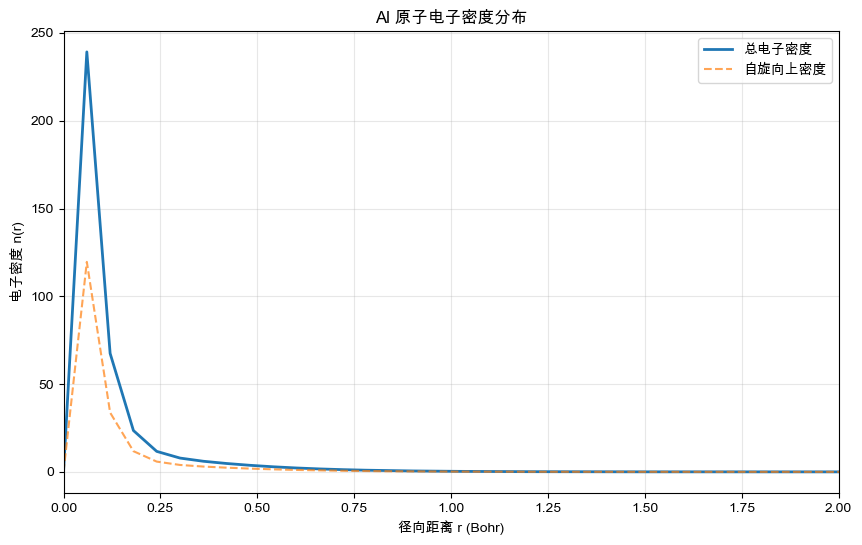

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(r, result.n_up + result.n_dn, label="总电子密度", linewidth=2)
plt.plot(r, result.n_up, "--", label="自旋向上密度", alpha=0.7)
# plt.plot(r, result.n_dn, "--", label="自旋向下密度", alpha=0.7)
plt.xlabel("径向距离 r (Bohr)")
plt.ylabel("电子密度 n(r)")
plt.title("Al 原子电子密度分布")
plt.xlim(0, 2)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 核心概念预览

### 径向网格

网格点数与精度的平衡：500 点足够基准测试，2000 点用于高精度计算。

### SCF 收敛

典型迭代次数：10-30 次（取决于初始猜测质量和混合参数）。

### 能量单位

AtomSCF 内部使用原子单位（Hartree），输出可转换为 eV：`1 Hartree = 27.211 eV`。

### 自旋索引

结果中的自旋通道使用字符串 `"up"` 和 `"down"` 索引，访问格式为 `eps_by_l_sigma[(l, "up")]`。

## 下一步

从 **[01-grid.ipynb](01-grid.ipynb)** 开始深入学习各模块！